# Lab-13: Ensemble Learning

In this lab, we will look at different ways to build ensemble models.


## Objectives:

* Bagging
* Random Forests
* AdaBoost


Why ensemble learning? How does it help? <span style="color:blue"> By combining the power of multiple models in a single model while overcoming their weaknesses, thus reducing variance and/or bias.

## Ensemble learning
We will explore ensemble learning on the example of decision trees - we will see how ensembles can improve classification accuracy.

Let's start from uploading MNIST dataset.

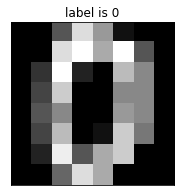

In [9]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

digits = load_digits()
X = digits.data
y = digits.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)


plt.figure(1, figsize=(3, 3))
plt.imshow(X[0].reshape((8,8)), cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title(f"label is {y[0]}")
plt.show()

### Single decision tree

First, we train a single decision tree.

In [10]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
pred = tree.predict(X_test)
tree_score = accuracy_score(y_test, pred)
print("Single tree accuracy:", tree_score)

Single tree accuracy: 0.8619528619528619


Note the accuracy - it is around **0.85**.

### Bagging


What is decreased by bagging? Variance or bias? How? <span style="color:blue"> Averaging reduces variance.
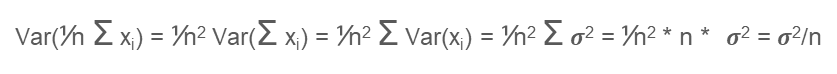

Now let's improve it a bit by the means of bagging. We train a hundred of independent classifiers and make a prediction by majority voting.

In [11]:
import numpy as np
from scipy.stats import mode

n_trees = 100

classifiers = []
for i in range(n_trees):
    # train a new classifier and append it to the list
    tree = DecisionTreeClassifier()
    tree.fit(X_train, y_train)
    classifiers.append(tree)

# here we will store predictions for all samples and all base classifiers
base_pred = np.zeros((X_test.shape[0], n_trees), dtype="int")
for i in range(n_trees):
    # obtain the predictions from each tree
    base_pred[:,i] = classifiers[i].predict(X_test)

print(base_pred)

# aggregate predictions by majority voting
pred = mode(base_pred, axis=1)[0].ravel()
acc = accuracy_score(y_test, pred)
print("Bagging accuracy:", acc)

[[3 3 3 ... 3 8 8]
 [8 8 8 ... 8 8 8]
 [2 2 2 ... 2 2 2]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [2 2 2 ... 2 2 2]]
Bagging accuracy: 0.8787878787878788


Now the accuracy grew up to **0.88**. You can see that our classifiers return very similar results. By the way, why the base classifiers are not identical at all? <span style="color:blue"> That is the case, if the improvement of the criterion is identical for several splits and one split has to be selected at random.


### Random forest

Compared to simple bagging we've just implemented, random forest can show better results because base classifiers are much less correlated.

At first, let's implement bootstrap sampling.

In [12]:
def bootstrap(X, y):
    # generate bootstrap indices and return data according to them
    ind = np.random.randint(0, X.shape[0], X.shape[0])
    return X[ind,:], y[ind]


# this is a test, will work if you are using np.random.randint() for indices generation
np.random.seed(0)
a = np.array(range(12)).reshape(4,3)
b = np.array(range(4))
bootstrap(a, b)

(array([[ 0,  1,  2],
        [ 9, 10, 11],
        [ 3,  4,  5],
        [ 0,  1,  2]]),
 array([0, 3, 1, 0]))

You should get

(array([[ 0,  1,  2], <br>
&emsp;&emsp;&emsp;[ 9, 10, 11], <br>
&emsp;&emsp;&emsp;[ 3,  4,  5], <br>
&emsp;&emsp;&emsp;[ 0,  1,  2]]), <br>
array([0, 3, 1, 0]))
       
Now let's build a set of decision trees, each of them is trained on a bootstrap sampling from X and $\sqrt d$ features.

In [13]:
classifiers = []
for i in range(n_trees):
    # train a new tree on sqrt(n_features) and bootstrapped data, append it to the list
    base = DecisionTreeClassifier(max_features="sqrt")
    bs_X, bs_y = bootstrap(X_train, y_train)
    base.fit(bs_X, bs_y)
    classifiers.append(base)

base_pred = np.zeros((n_trees, X_test.shape[0]), dtype="int")
for i in range(n_trees):
    base_pred[i,:] = classifiers[i].predict(X_test)

pred = mode(base_pred, axis=0)[0].ravel()
acc = accuracy_score(y_test, pred)
print("Random forest accuracy:", acc)

Random forest accuracy: 0.9814814814814815


And now we got **0.97** accuracy, which is a significant improvement! Now you can see why it is so important to have diverse classifiers.

## Boosting

How does boosting work? <span style="color:blue"> Models are built sequentially: each model is built using information from previously built models. Boosting does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set.

For simplicity let's make a binary classification problem out of the original problem.

In [14]:
y_train_b = (y_train == 2 ) * 2 - 1
y_test_b = (y_test == 2 ) * 2 - 1

Now let's train a boosting model.

We will have sample weights and tree weights. Initially all sample weights are equal. After that we will increase weight for complicated samples.

Tree weight $w$ is computed using weighted error or $1 - accuracy$

$w_t = \frac12 log(\frac{1-weighted\_error_t}{weighted\_error_t})$ for each base classifier.

For correct samples weights will be decreased $e^w$ times, and for incorrect classified samples increased  $e^w$ times. After this changes we normalize weights.

In [15]:
n_trees = 10
tree_weights = np.zeros(n_trees)
classifiers = []
train_samples = X_train.shape[0]
# initialize sample weights
sample_weights = np.ones(train_samples) / train_samples
for i in range(n_trees):
    clf = DecisionTreeClassifier(min_samples_leaf=3)
    clf.fit(X_train, y_train_b, sample_weight=sample_weights)
    pred = clf.predict(X_train)
    acc = accuracy_score(y_train_b, pred, sample_weight=sample_weights)
    # caclulate tree weight
    w = 0.5 * np.log(acc / (1 - acc))
    tree_weights[i] = w
    classifiers.append(clf)
    # update sample weights
    for j in range(train_samples):
        if pred[j] != y[j]:
            sample_weights[j] = sample_weights[j] * np.exp(w)
        else:
            sample_weights[j] = sample_weights[j] * np.exp((-w))
    # normalize the weights
    sample_weights = sample_weights / np.sum(sample_weights)

Use trees voting to calculate final predictions. Since we have a binary classification, the prediction will be calculated as follows:

$\hat{y} = sign(\sum_{t=1}^{T}(w_t f_t(x)))$

In [16]:
n_test = X_test.shape[0]

pred = np.zeros(n_test)
# caclulate predictions
for t in range(n_trees):
    pred += classifiers[t].predict(X_test) * tree_weights[t]
for i in range(n_test):
    pred[i] = 1 if pred[i] > 0 else -1


acc = accuracy_score(y_test_b, pred)
print("Boosting accuracy:", acc)

Boosting accuracy: 0.9730639730639731


The resulting accuracy is **0.97**